In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
np.random.seed(42)

In [ ]:
df = pd.read_csv("./data/advertising-budgets.csv")


In [ ]:
X = df[["TV Ad Budget ($)", "Radio Ad Budget ($)", "Newspaper Ad Budget ($)"]]
y = df["Sales ($)"]

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_b = np.c_[np.ones((X.shape[0], 1)), X]

In [ ]:
coefficients = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
intercept = coefficients[0]
coefficients = coefficients[1:]
print(intercept, coefficients)

In [ ]:
y_predictions = intercept + np.dot(X, coefficients)

In [ ]:
plt.scatter(y, y_predictions)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color="red")
plt.xlabel("Actual Sales ($)")
plt.ylabel("Predicted Sales ($")
plt.title("Actual vs. Predicted Sales (Millions)")
plt.grid()
plt.show()

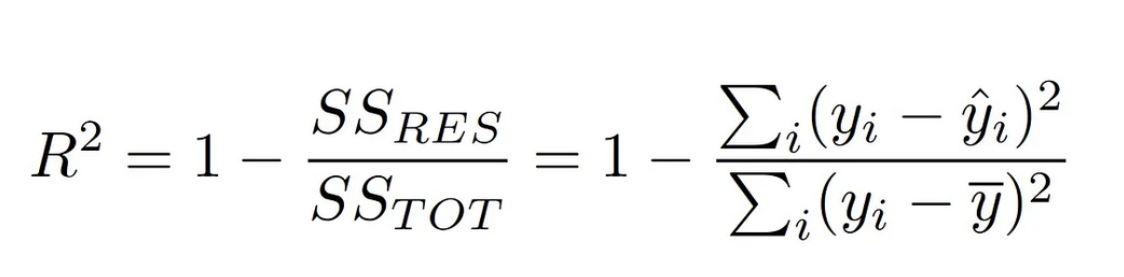

In [45]:
r_squared = 1 - np.sum((y - y_predictions) ** 2) / np.sum((y - np.mean(y)) ** 2)
r_squared

np.float64(0.8972106381789522)

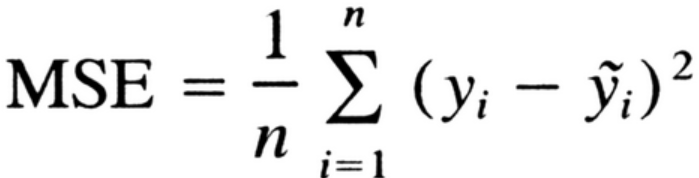

In [47]:
mse = 1 / len(X) * np.sum((y - y_predictions) ** 2)
mse

np.float64(2.784126314510936)

In [48]:
rmse = math.sqrt(mse)
rmse

1.6685701407225697